In [1]:
import numpy as np
import matplotlib.pyplot as plt

import IPython
import scipy.io.wavfile as wav
import scipy.signal as ss

In [2]:
def compareToOriginalSignal(newSignal, originalSignal):
    plt.figure(figsize=(12, 3))
    plt.subplot(121)
    plt.title('New signal')
    plt.plot(newSignal)

    plt.subplot(122)
    plt.title('Original signal')
    plt.plot(originalSignal)

    plt.show()

# Phasing

$H(z) = 1 + a \, z ^{-p} \iff y(n) = x(n) + a(n)\, x(n-p)$

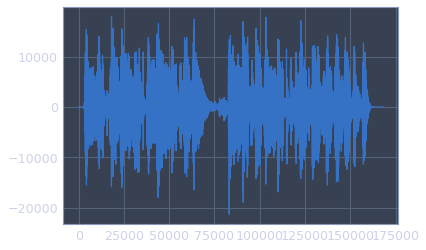

In [3]:
sons = ["./Sons/guitare.wav", "./Sons/hand_clap_22mono.wav", "./Sons/paganini.wav"]
frameRate, frames = wav.read(sons[0])

plt.plot(frames)
plt.show()

IPython.display.Audio(frames, rate=frameRate)

In [4]:
def phasing(signal, fa=2, aminmax=(0.5, 1), p=10):
    am, aM = aminmax
    a = (am + aM) / 2 + (aM - am) / 2 * np.sin(2 * np.pi * fa * np.arange(len(signal)))

    return signal + a * np.concatenate((np.zeros(p), signal[:-p]))

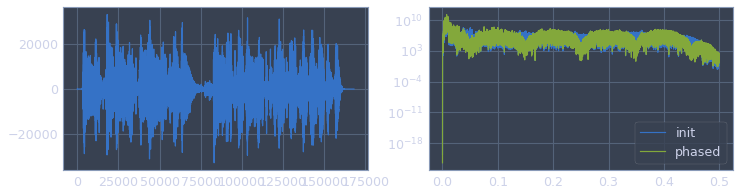

In [5]:
phasingEffect = {
    "fa": 2,
    "aminmax": (0.9, 1),
    "p": 10
}

phased = phasing(frames.astype(np.float), **phasingEffect)

plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.plot(phased)

plt.subplot(122)
plt.semilogy(*ss.periodogram(frames), label="init")
plt.semilogy(*ss.periodogram(phased), label="phased")
plt.legend()
plt.show()

IPython.display.Audio(phased, rate=frameRate)

Pour différentes valeurs de $a$, les résultats diffèrent grandement. Lorsque $a_{min}$ et $a_{max}$ sont proches de 1, on note un effet maximal.

# Flanger

1. $H(z) = 1 + a \, z ^{-p} \iff y(n) = x(n) + a\, x\big(n-p(n)\big)$

In [6]:
def flanger(signal, frameRate=1, fp=200, pminpmax=(0.5, 1), a=1):
    pm, pM = pminpmax
    p = (pm + pM) / 2 + (pM - pm) / 2 * np.sin(2 * np.pi * fp * np.arange(len(signal)) / frameRate)

    return signal + a * signal[np.arange(len(signal)) - p.astype(np.int)]

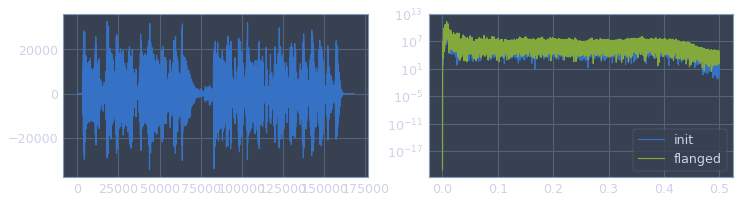

In [7]:
flangerEffect = {
    "fp": 4,
    "pminpmax": (5, 15),
    "a": 1
}

flanged = flanger(frames.astype(np.float), frameRate, **flangerEffect)

plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.plot(flanged)

plt.subplot(122)
plt.semilogy(*ss.periodogram(frames), label="init")
plt.semilogy(*ss.periodogram(flanged), label="flanged")
plt.legend()
plt.show()

IPython.display.Audio(flanged, rate=frameRate)

De nouveau, pour différentes valeurs de $a$, les résultats diffèrent grandement. Lorsque $a_{min}$ et $a_{max}$ sont proches de 1, on note un effet maximal.

# Artificial reverberation

## Early Echo Sources

1.
Walls have a texture, which influences a lot how sounds are reflected / reverberated: how much the walls absorb such or such frequency would help build a more realistic model.

2.
* Direct sound: 1 source;
* First order echoes: 6 additional sources (1 for each wall) with $w=6$; in our case, as the source is in (0,0,0), there are only 3 additional sources (emitted by walls which do not already touch the original source)
* Second order echoes: 30 additional sources (1 for each combinasion of distinct walls ${w}\choose{2}$;

3.
Realistically speaking, if a wall absorbs 75% of the signal, two reverberations leave us with only 1/8 of the original signal. Moreover, part of the original signal is also lost in diffraction / diffusion. Eventually, only a very small fraction of the original intensity remains after two echos, therefore higher order echoes can be neglected.

In [8]:
def computeEchoSources(sourcePosition, micPosition, roomDimensions, accDistance=0):
    newSources = []

    for dimension, limit in enumerate(roomDimensions):
        for wallCoordinate in [0, limit]:
            # Compute the symmetry of the source
            # with regard to one of the walls
            newSourcePosition = list(sourcePosition)
            newSourcePosition[dimension] = wallCoordinate - (sourcePosition[dimension] - wallCoordinate)
            
            # Project the position inside the room
            newSourceProjectedPosition = list(newSourcePosition)
            newSourceProjectedPosition[dimension] = wallCoordinate

            remainingDimensions = set([0,1,2])
            remainingDimensions.remove(dimension)

            for d in remainingDimensions:
                # Thales
                if (2 * wallCoordinate - micPosition[dimension]):
                    newSourceProjectedPosition[d] =\
                        micPosition[d] *\
                        wallCoordinate /\
                        (2 * wallCoordinate - micPosition[dimension])
                else:
                    newSourceProjectedPosition[d] = 0
            
            newSources.append(newSourceProjectedPosition)

    newSources = list(filter(lambda s: (not s == sourcePosition and not s == micPosition), newSources))
    newSources = list(map(
        lambda s: {
            'accDistance': accDistance + computeDistance(sourcePosition, s),
            'distanceToMic': computeDistance(s, micPosition),
            'position': s,
        },
        newSources
    ))

    return newSources

In [9]:
def computeDistance(p1, p2):
    a1 = np.array(p1)
    a2 = np.array(p2)
    a = a2 - a1

    d = np.sqrt(np.sum(a * a))
    return d

def computeFrameShift(frameRate, d1, d2):
    soundVelocity = 300
    timeDelta = abs(d2 - d1) / soundVelocity
    
    return int(timeDelta * frameRate)

def attenuation(r):
    return 1 / r if r >= 1 else 1

In [10]:
def computeEarlyEchoSignal(sourcePosition, micPosition, roomDimensions, signal, frameRate):
    output = np.array(signal).astype(np.float)
    
    originalSource = {
        'accDistance': 0,
        'distanceToMic': computeDistance(sourcePosition, micPosition),
        'position': sourcePosition
    }
    currentSources = [originalSource]
    echoSources = []
    
    echoOrders = 2
    
    for _ in range(echoOrders):
        # Computes echo sources
        for source in currentSources:
            currentEchoSources = computeEchoSources(source['position'], micPosition, roomDimensions,
                                                    accDistance=source['accDistance'])
            echoSources = np.concatenate((echoSources, currentEchoSources))

        # Modifies signal with echo sources
        for source in echoSources:
            shift = computeFrameShift(frameRate,
                                      originalSource['distanceToMic'],
                                      source['accDistance'] + source['distanceToMic'])
            output += attenuation(source['accDistance'] + source['distanceToMic']) *\
                np.concatenate((signal[shift:], np.zeros(shift)))

        currentSources = list(echoSources)
        echoSources = []

    return output

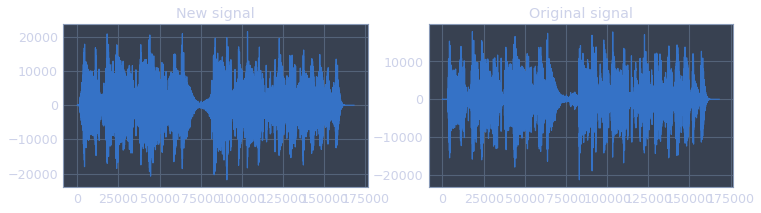

In [11]:
sourcePosition = [0, 0, 0]
micPosition = [2, 2, 2]
roomDimensions = [10, 10, 10]
echoed = computeEarlyEchoSignal(sourcePosition, micPosition, roomDimensions, frames, frameRate)

compareToOriginalSignal(echoed, frames)
IPython.display.Audio(echoed, rate=frameRate)

Le système précédent fonctionne comme suit :
- la fonction `computeEchoSources` prend en argument la position de la source, du micro et les dimensions de la pièce afin de calculer les coordonnées - projetées sur les murs de la pièce - des échos dûs à la source; comme cette fonction est appelée récursivement, l'utilisation d'une variable `accDistance` permet de calculer récursivement le décalage des sources écho par rapport à la source mère
- les fonctions utilitaires `computeDistance`, `computeFrameShift` et `attenuation` dont les noms sont explicites
- la fonction `computeEarlyEchoSignal` qui calcule les sources écho sur deux niveaux et ajoute leur contribution (avec le décalage temporel associé) au signal source.

Le résultat produit semble cohérent.

## Late reverberation: Schroeder reverberator

1.
$$g_i = 10^{\frac{-3 m_i T}{T_r}}$$

$$g_i = \exp\big(m_i \log(1 - \frac{7T}{T_r})\big)$$

In [12]:
def computeGain(T, Tr, m, model='comb'):
    return {
        'comb': lambda: 10 ** (-3 * m * T / Tr),
        'allpass': lambda: np.exp(m * np.log(1 - 7 * T / Tr)),
    }.get(model, lambda: None)()
    
def comb(signal, amplitude, shift):
    return signal + amplitude * np.concatenate((np.zeros(shift), signal[:-shift]))

def allpass(signal, amplitude, shift):
    return (
        signal + 
        amplitude * np.concatenate((np.zeros(shift), signal[:-shift])) -
        amplitude * np.concatenate((signal[shift:], np.zeros(shift)))
    )

def schroeder(signal, frameRate, combDelays, allPassDelays):
    output = np.array(signal).astype(np.float)
    T = 1 / frameRate
    Tr = 2

    for delay in combDelays:
        output += comb(output, computeGain(T, Tr, delay, model='comb'), int(delay * frameRate))

    for delay in allPassDelays:
        output += allpass(output, computeGain(T, Tr, delay, model='allpass'), int(delay * frameRate))

    return output

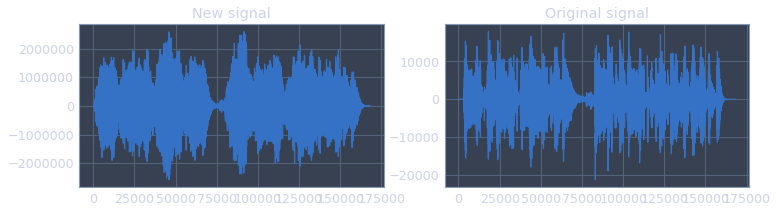

In [13]:
combDelays = np.array((29.7, 37.1, 41.4, 43.7)) * 1e-3
allPassDelays = np.array((96.83, 32.92)) * 1e-3

reverb = schroeder(frames, frameRate, combDelays, allPassDelays)

compareToOriginalSignal(reverb, frames)
IPython.display.Audio(reverb, rate=frameRate)

Le système précédent fonctionne comme suit :
- les fonctions `computeGain`, `comb` et `allpass` sont des utilitaires assez explicites
- la fonction `schroeder` utilise les fonctions utilitaires précédemment introduites pour modifier un signal source en accord avec les transformations présentées dans le TD)

Le résultat sonore produit est concluant.

## Merging the two systems

On peut combiner les fonctions `computeEarlyEchoSignal` et `schroeder` pour générer un écho selon le modèle présenté en TD. Ici, la réverbération est appelée pour chaque source écho avec le décalage inhérent à cette source écho.

In [14]:
def computeEcho(sourcePosition, micPosition, roomDimensions, signal, frameRate):
    output = np.array(signal).astype(np.float)
    
    originalSource = {
        'accDistance': 0,
        'distanceToMic': computeDistance(sourcePosition, micPosition),
        'position': sourcePosition
    }
    currentSources = [originalSource]
    echoSources = []
    
    echoOrders = 2
    
    for _ in range(echoOrders):
        # Computes echo sources
        for source in currentSources:
            currentEchoSources = computeEchoSources(source['position'], micPosition, roomDimensions,
                                                    accDistance=source['accDistance'])
            echoSources = np.concatenate((echoSources, currentEchoSources))

        # Modifies signal with echo sources
        for source in echoSources:
            shift = computeFrameShift(frameRate,
                                      originalSource['distanceToMic'],
                                      source['accDistance'] + source['distanceToMic'])
            output +=\
                schroeder(
                    attenuation(source['accDistance'] + source['distanceToMic']) *\
                        np.concatenate((signal[shift:], np.zeros(shift))),
                    frameRate, combDelays, allPassDelays
                )

        currentSources = list(echoSources)
        echoSources = []

    return output

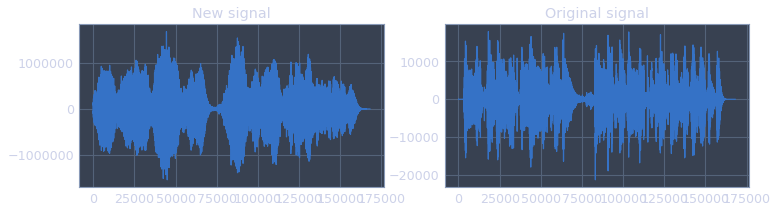

In [15]:
echoedAndReverb = computeEcho(sourcePosition, micPosition, roomDimensions, frames, frameRate)

compareToOriginalSignal(echoedAndReverb, frames)
IPython.display.Audio(echoedAndReverb, rate=frameRate)

On peut tester ce modèle avec différents paramètres : la réverbération notamment peut être rendue plus réaliste.